![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 10 - RNN</center>
### <center> Vanilla RNN</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/10_RNN/MainVanillaRNN.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn          as nn
import torch.optim       as optim
import torchsummary

from torch.optim import lr_scheduler

matplotlib.rc('font', **{'size' : 16})

For Colab users:

In [3]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/10_RNN/DeepLearningFramework ./DeepLearningFramework

#### Dataset:

In [6]:
#-- A simple sequence dataset:
class SequenceDataset(torch.utils.data.Dataset):
    def __init__(self, lX, vY):
        self.lX = lX
        self.vY = vY
        
    def __len__(self):
        return len(self.lX)
    
    def __getitem__(self, idx):
        vXi = self.lX[idx]
        yi  = self.vY[idx]
        return vXi, yi

In [9]:
from torch.nn.utils.rnn import pack_sequence

def SequenceCollateFunction(lBatch):
    
    lX, lY = zip(*lBatch)
    vY     = torch.tensor(lY, dtype=torch.float32)
    mPackX = pack_sequence(lX, enforce_sorted=False)
    
    return mPackX, vY


batchSize = 128
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   collate_fn=SequenceCollateFunction)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, collate_fn=SequenceCollateFunction)

### Exercise
* The goal is to estimate the following function:
![f_x](https://github.com/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/10_RNN//f_x.png?raw=true)
* Train an RNN model and get $R^2$ above `0.99`.

#### Generate data:

In [16]:
minL   = 5
maxL   = 30
nTrain = 50000
nTest  = 10000
N      = nTrain + nTest

vY = torch.zeros(N)
lX = [None] * N
for ii in range(N):
    L       = np.random.randint(minL, maxL)
    vX      = torch.rand(L, 1)
    idx     = np.random.randint(L)
    vX[idx] = -1
    lX[ii]  = vX
    vY[ii]  = torch.sum(vX[:idx]**2) - torch.sum(vX[idx+1:]**2)

In [17]:
lTrainX = lX[:nTrain]
vTrainY = vY[:nTrain]
lTestX  = lX[nTrain:]
vTestY  = vY[nTrain:]

oTrainSet = SequenceDataset(lTrainX, vTrainY.float())
oTestSet  = SequenceDataset(lTestX,  vTestY .float())

In [18]:
batchSize = 128
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   collate_fn=SequenceCollateFunction)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, collate_fn=SequenceCollateFunction)

### Model:

In [19]:
class RnnModel(nn.Module):
    def __init__(self):
        super(RnnModel, self).__init__() #-- always do this
        
        H         = 100
        self.oRnn = nn.RNN   (input_size=1, hidden_size=H, batch_first=True, num_layers=5)
        self.oFC  = nn.Linear(H, 1)

    def forward(self, mPackX):
                                   #-- mPackX.shape = (N*T,)
        _, mH  = self.oRnn(mPackX) #-- mH    .shape = (1, N, H)
        vY     = self.oFC (mH[0])  #-- vY    .shape = (N, 1)
        
        return vY[:,0]

lX, vY = next(iter(oTrainDL))
RnnModel()(lX).shape

torch.Size([128])

In [20]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
Loss   = nn.MSELoss()

In [21]:
from torch.optim                    import lr_scheduler
from DeepLearningFramework.Training import TrainRegressionModel

nEpochs       = 30
nIter         = nEpochs * len(oTrainDL)
oModel        = RnnModel().to(DEVICE)
oOptim        = optim.Adam(oModel.parameters(), lr=5e-5, betas=(0.8, 0.9))
oScheduler    = lr_scheduler.OneCycleLR(oOptim, max_lr=5e-3, total_steps=nIter)
lHistory      = TrainRegressionModel(oModel, oTrainDL, oTestDL, Loss, nEpochs, oOptim, oScheduler);

Epoch 000: | Train loss: 10.12585 | Val loss: 6.31147 | Train R2: +0.2667 | Val R2: +0.5325 | epoch time:  4.591 | <-- Checkpoint!
Epoch 001: | Train loss: 5.91932 | Val loss: 5.34384 | Train R2: +0.5702 | Val R2: +0.6041 | epoch time:  4.765 | <-- Checkpoint!
Epoch 002: | Train loss: 5.02128 | Val loss: 4.08738 | Train R2: +0.6348 | Val R2: +0.6959 | epoch time:  4.677 | <-- Checkpoint!
Epoch 003: | Train loss: 3.24725 | Val loss: 1.97093 | Train R2: +0.7639 | Val R2: +0.8539 | epoch time:  4.623 | <-- Checkpoint!
Epoch 004: | Train loss: 0.87347 | Val loss: 0.70190 | Train R2: +0.9366 | Val R2: +0.9479 | epoch time:  4.605 | <-- Checkpoint!
Epoch 005: | Train loss: 0.67820 | Val loss: 0.52049 | Train R2: +0.9509 | Val R2: +0.9615 | epoch time:  4.577 | <-- Checkpoint!
Epoch 006: | Train loss: 0.78170 | Val loss: 1.04745 | Train R2: +0.9426 | Val R2: +0.9221 | epoch time:  4.562 |
Epoch 007: | Train loss: 0.86039 | Val loss: 0.22247 | Train R2: +0.9374 | Val R2: +0.9836 | epoch time: 

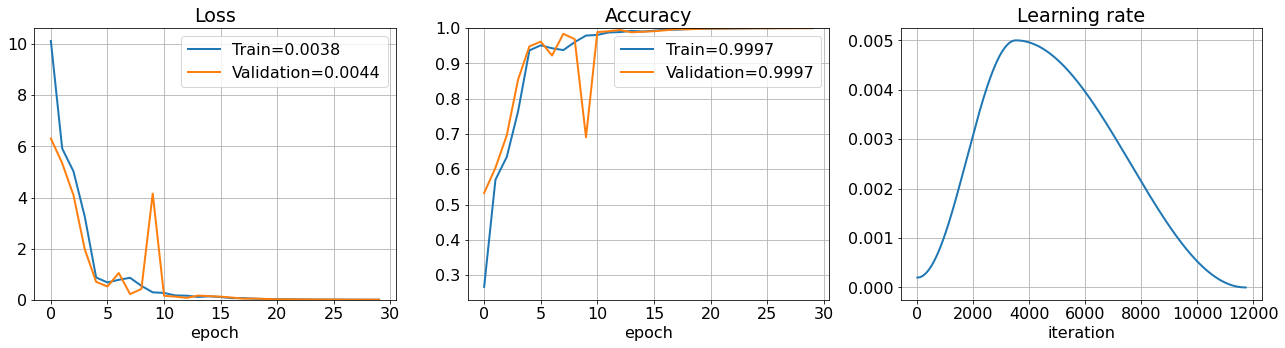

In [22]:
PlotHistory(lHistory)